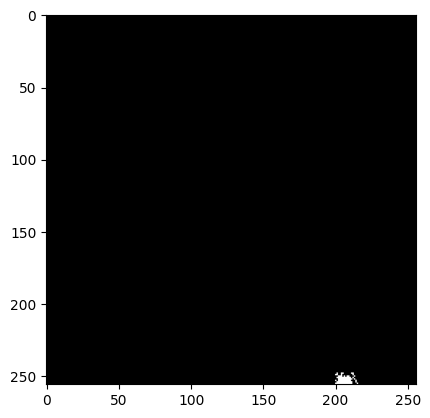

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_mask_from_npz(npz_file_path):
    """Creates a binary mask from polygons stored in an NPZ file.

    Args:
        npz_file_path (str): Path to the NPZ file containing polygon data.

    Returns:
        np.ndarray: The binary mask (256x256).
    """
    
    # Load data from the NPZ file
    with np.load(npz_file_path) as f:
        # Get all arrays from the NPZ file
        polygon_arrays = [v for k, v in f.items() if k.startswith('arr_')]
        
    # Create an empty mask (black) with the fixed dimensions
    mask = np.zeros((256, 256), dtype=np.uint8)  # Use uint8 for binary mask

    # Iterate over each polygon array and fill the mask
    for polygons in polygon_arrays:
        if polygons.ndim == 2 and polygons.shape[1] == 2:  # Check if valid polygon format
            mask = cv2.fillPoly(mask, pts=[polygons], color=255) # White for filled area

    # Apply Gaussian blur for anti-aliasing (optional)
    #mask = cv2.GaussianBlur(mask, (0, 0), sigmaX=2, sigmaY=2, borderType=cv2.BORDER_DEFAULT)

    return mask

# Example usage
npz_file = "/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/label/79114_50991.npz"
result_mask = create_mask_from_npz(npz_file)

# Save or display the results
plt.imshow(result_mask,cmap="gray")  # Display using matplotlib


In [2]:
cv2.imwrite("filled_polygon_multiple.jpg", result_mask)

True

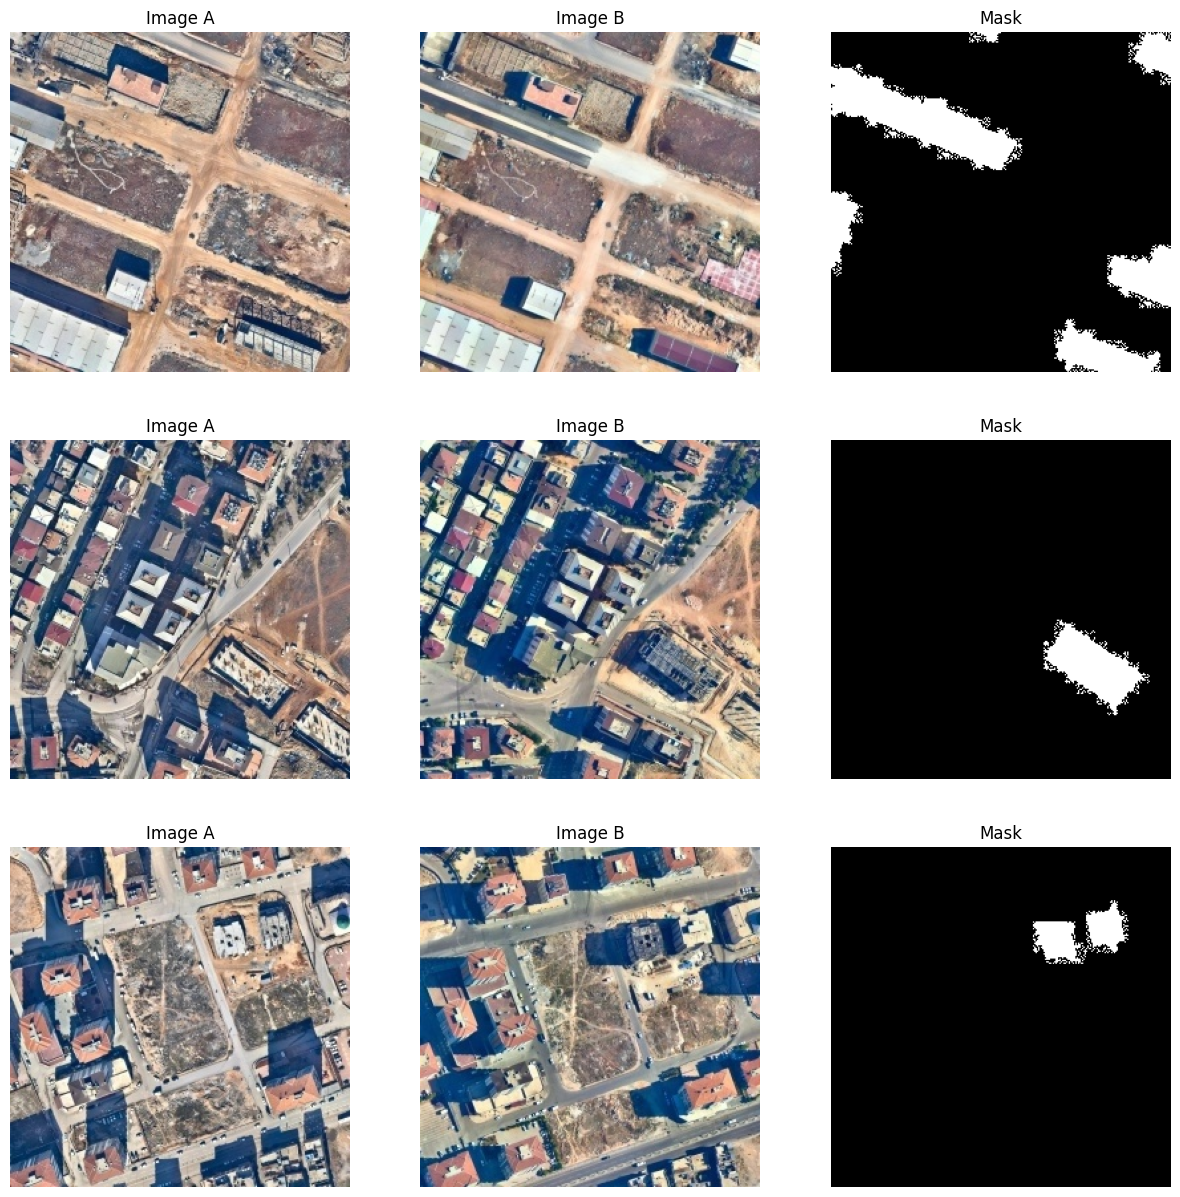

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

class ChangeDetectionDataset(Dataset):
    def __init__(self, image_dir_A, image_dir_B, mask_dir, transform=None):
        self.image_dir_A = image_dir_A
        self.image_dir_B = image_dir_B
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir_A)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_A_name = self.image_names[idx]
        img_B_name = img_A_name  # Assuming both image sets have the same filenames

        img_A_path = os.path.join(self.image_dir_A, img_A_name)
        img_B_path = os.path.join(self.image_dir_B, img_B_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(img_A_name)[0] + '.npz')

        image_A = Image.open(img_A_path).convert('RGB')
        image_B = Image.open(img_B_path).convert('RGB')

        mask = create_mask_from_npz(mask_path)

        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image_A, image_B, mask

    def load_mask(self, mask_path, image_size):
        mask_data = np.load(mask_path, allow_pickle=True)
        mask = Image.new('L', image_size, 0)
        draw = ImageDraw.Draw(mask)

        for key in mask_data.files:
            polygons = mask_data[key]
            for polygon in polygons:
                draw.polygon(polygon, outline=1, fill=1)

        mask_array = np.array(mask)
        print(f"Loaded mask from {mask_path} with unique values: {np.unique(mask_array)}")
        return mask_array

# Define paths
image_dir_A = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newA'
image_dir_B = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newB'
mask_dir = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/label'

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset and dataloader
dataset = ChangeDetectionDataset(image_dir_A, image_dir_B, mask_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

def plot_images_and_masks(dataset, num_images=3):
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    
    for i in range(num_images):
        img_A, img_B, mask = dataset[i]
        
        axs[i, 0].imshow(img_A.permute(1, 2, 0))
        axs[i, 0].set_title('Image A')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(img_B.permute(1, 2, 0))
        axs[i, 1].set_title('Image B')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(mask.squeeze(), cmap='gray')
        axs[i, 2].set_title('Mask')
        axs[i, 2].axis('off')

    plt.show()

# Plot a few images and their masks
plot_images_and_masks(dataset)


100%|██████████| 209/209 [00:09<00:00, 21.45it/s]


Epoch 1/20, Loss: 0.031916174482839385


100%|██████████| 209/209 [00:09<00:00, 21.04it/s]


Epoch 2/20, Loss: 0.002312184337072039


100%|██████████| 209/209 [00:09<00:00, 21.93it/s]


Epoch 3/20, Loss: 0.0022340873509765777


100%|██████████| 209/209 [00:09<00:00, 21.40it/s]


Epoch 4/20, Loss: 0.0021975914227473216


100%|██████████| 209/209 [00:09<00:00, 21.24it/s]


Epoch 5/20, Loss: 0.002196354869225076


100%|██████████| 209/209 [00:09<00:00, 21.54it/s]


Epoch 6/20, Loss: 0.0021407028301463032


100%|██████████| 209/209 [00:10<00:00, 20.81it/s]


Epoch 7/20, Loss: 0.0021457666716132866


100%|██████████| 209/209 [00:09<00:00, 21.21it/s]


Epoch 8/20, Loss: 0.0021216206405195964


100%|██████████| 209/209 [00:09<00:00, 21.56it/s]


Epoch 9/20, Loss: 0.002095608840976133


100%|██████████| 209/209 [00:09<00:00, 21.67it/s]


Epoch 10/20, Loss: 0.0021214292066630744


100%|██████████| 209/209 [00:10<00:00, 20.68it/s]


Epoch 11/20, Loss: 0.0020910068403965122


100%|██████████| 209/209 [00:10<00:00, 20.31it/s]


Epoch 12/20, Loss: 0.002094624904803174


100%|██████████| 209/209 [00:10<00:00, 19.58it/s]


Epoch 13/20, Loss: 0.0021214353251516036


100%|██████████| 209/209 [00:10<00:00, 20.50it/s]


Epoch 14/20, Loss: 0.002091733276460801


100%|██████████| 209/209 [00:10<00:00, 20.72it/s]


Epoch 15/20, Loss: 0.002125131844294494


100%|██████████| 209/209 [00:09<00:00, 20.94it/s]


Epoch 16/20, Loss: 0.002124285642904314


100%|██████████| 209/209 [00:09<00:00, 21.01it/s]


Epoch 17/20, Loss: 0.002088718468732196


100%|██████████| 209/209 [00:10<00:00, 20.90it/s]


Epoch 18/20, Loss: 0.0021032062013807335


100%|██████████| 209/209 [00:10<00:00, 20.33it/s]


Epoch 19/20, Loss: 0.00208852341611375


100%|██████████| 209/209 [00:10<00:00, 20.87it/s]


Epoch 20/20, Loss: 0.0020718470864158353


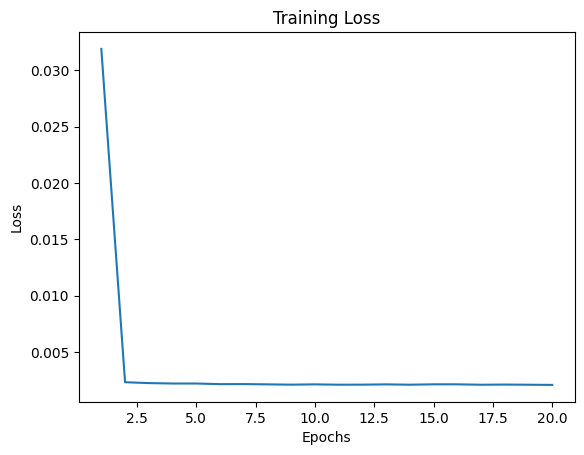

In [10]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import cv2

class ChangeDetectionDataset(Dataset):
    def __init__(self, image_dir_A, image_dir_B, mask_dir, transform=None):
        self.image_dir_A = image_dir_A
        self.image_dir_B = image_dir_B
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir_A)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_A_name = self.image_names[idx]
        img_B_name = img_A_name  # Assuming both image sets have the same filenames

        img_A_path = os.path.join(self.image_dir_A, img_A_name)
        img_B_path = os.path.join(self.image_dir_B, img_B_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(img_A_name)[0] + '.npz')

        image_A = Image.open(img_A_path).convert('RGB')
        image_B = Image.open(img_B_path).convert('RGB')

        mask = create_mask_from_npz(mask_path)

        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image_A, image_B, mask

def create_mask_from_npz(npz_file_path):
    with np.load(npz_file_path) as f:
        polygon_arrays = [v for k, v in f.items() if k.startswith('arr_')]
    
    mask = np.zeros((256, 256), dtype=np.uint8)
    
    for polygons in polygon_arrays:
        if polygons.ndim == 2 and polygons.shape[1] == 2:
            mask = cv2.fillPoly(mask, pts=[polygons], color=1)
    
    # Normalize mask to range [0, 1]
    mask = mask / 255.0
    
    return mask

class SimpleChangeDetectionModel(nn.Module):
    def __init__(self):
        super(SimpleChangeDetectionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define paths
image_dir_A = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newA'
image_dir_B = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newB'
mask_dir = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/label'

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset and dataloader
dataset = ChangeDetectionDataset(image_dir_A, image_dir_B, mask_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize model, loss function, and optimizer
model = SimpleChangeDetectionModel().cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images_A, images_B, masks in tqdm(train_loader):
        images_A = images_A.cuda()
        images_B = images_B.cuda()
        masks = masks.cuda()

        optimizer.zero_grad()
        outputs = model(images_A, images_B)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

# Plotting the loss
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [5]:
import matplotlib.pyplot as plt

def predict_and_plot(model, image_dir_A, image_dir_B, transform, image_pairs, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    fig, axs = plt.subplots(len(image_pairs), 3, figsize=(15, 5 * len(image_pairs)))

    for i, (img_A_name, img_B_name) in enumerate(image_pairs):
        # Load and preprocess the images
        img_A_path = os.path.join(image_dir_A, img_A_name)
        img_B_path = os.path.join(image_dir_B, img_B_name)
        image_A = Image.open(img_A_path).convert('RGB')
        image_B = Image.open(img_B_path).convert('RGB')

        if transform:
            image_A = transform(image_A).unsqueeze(0).to(device)
            image_B = transform(image_B).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_A, image_B)
            prediction = torch.sigmoid(output).cpu().squeeze().numpy()

        # Plot the results
        axs[i, 0].imshow(Image.open(img_A_path))
        axs[i, 0].set_title('Image A')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(Image.open(img_B_path))
        axs[i, 1].set_title('Image B')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(prediction, cmap='gray')
        axs[i, 2].set_title('Predicted Mask')
        axs[i, 2].axis('off')

    plt.show()

# Example usage:
model = SimpleChangeDetectionModel().cuda()
model.load_state_dict(torch.load('path_to_saved_model.pth'))  # Load your trained model

# Define the transform used during training
transform = transforms.Compose([
    transforms.ToTensor()
])



FileNotFoundError: [Errno 2] No such file or directory: 'path_to_saved_model.pth'

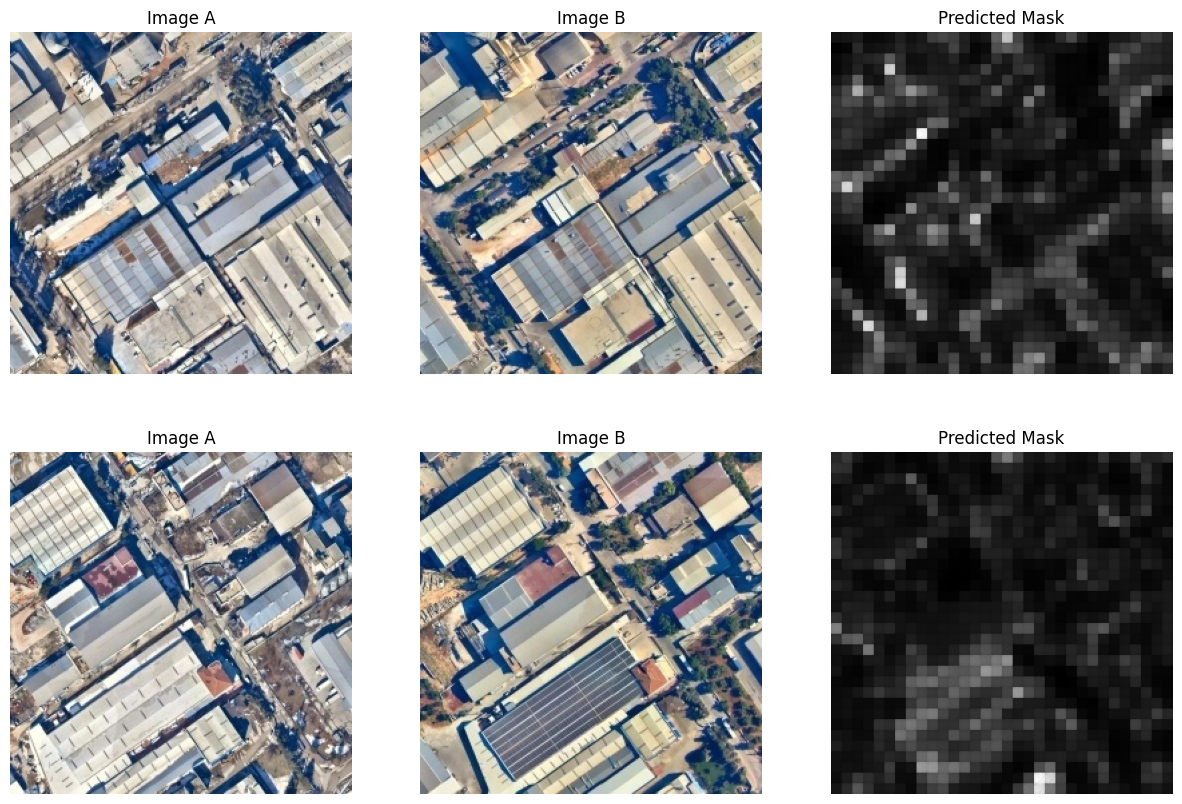

In [11]:
# Define the image pairs to predict on
image_pairs = [
    ('/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/A/79113_50951.jpg', '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/B/79113_50951.jpg'),
    ('/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/A/79113_50952.jpg', '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/B/79113_50952.jpg')
]
image_dir_A="/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/A"
image_dir_B="/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/B"
# Make predictions and plot results
predict_and_plot(model, image_dir_A, image_dir_B, transform, image_pairs)

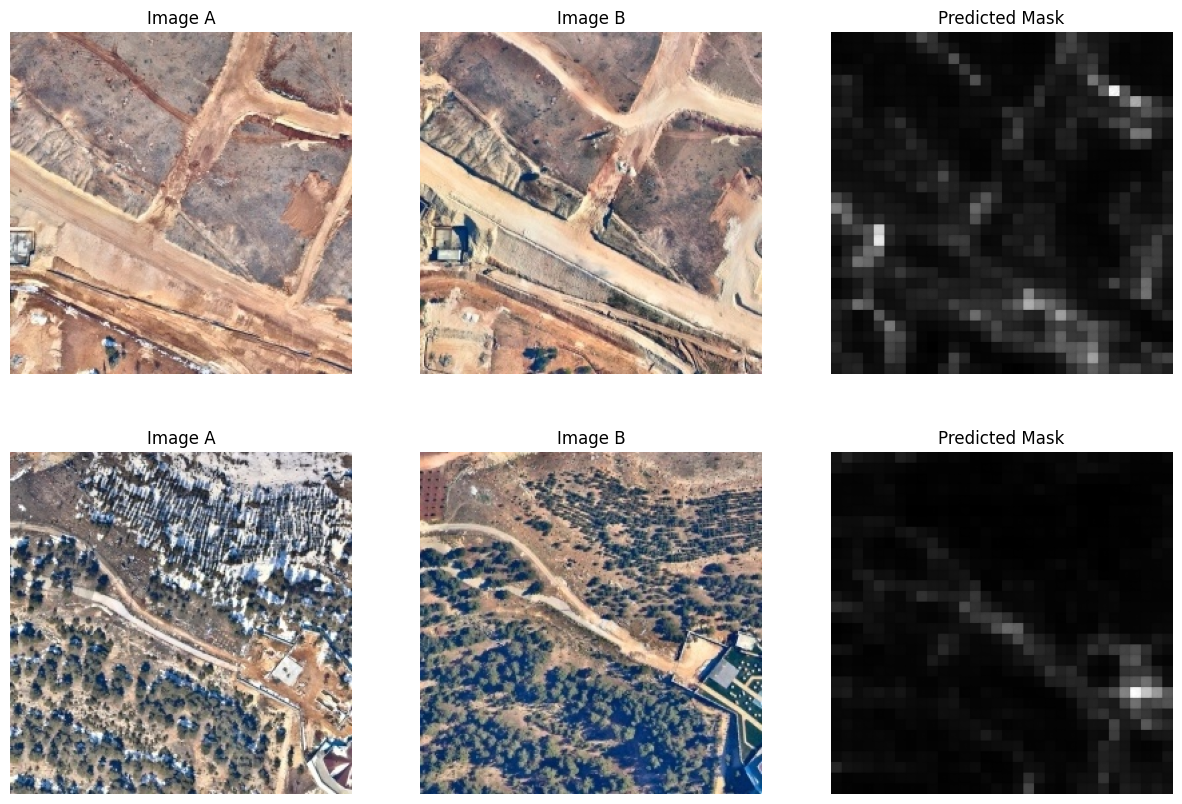

In [12]:
# Define the image pairs to predict on
image_pairs = [
    ('/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newA/79113_50987.jpg', '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newB/79113_50987.jpg'),
    ('/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newA/79114_50959.jpg', '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newB/79114_50959.jpg')
]
image_dir_A="/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newA"
image_dir_B="/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newB"
# Make predictions and plot results
predict_and_plot(model, image_dir_A, image_dir_B, transform, image_pairs)

100%|██████████| 209/209 [00:31<00:00,  6.69it/s]


Epoch 1/20, Loss: 0.2474378060424727


100%|██████████| 209/209 [00:31<00:00,  6.73it/s]


Epoch 2/20, Loss: 0.17976574917016416


100%|██████████| 209/209 [00:31<00:00,  6.73it/s]


Epoch 3/20, Loss: 0.17107709714670502


100%|██████████| 209/209 [00:31<00:00,  6.68it/s]


Epoch 4/20, Loss: 0.16493181853987385


100%|██████████| 209/209 [00:31<00:00,  6.65it/s]


Epoch 5/20, Loss: 0.1647943198752175


100%|██████████| 209/209 [00:31<00:00,  6.65it/s]


Epoch 6/20, Loss: 0.1592880034703387


100%|██████████| 209/209 [00:31<00:00,  6.73it/s]


Epoch 7/20, Loss: 0.15703360693591634


100%|██████████| 209/209 [00:31<00:00,  6.66it/s]


Epoch 8/20, Loss: 0.156431056416491


100%|██████████| 209/209 [00:31<00:00,  6.70it/s]


Epoch 9/20, Loss: 0.14995466796547602


100%|██████████| 209/209 [00:31<00:00,  6.69it/s]


Epoch 10/20, Loss: 0.15208010539483796


100%|██████████| 209/209 [00:31<00:00,  6.72it/s]


Epoch 11/20, Loss: 0.14769945111856506


100%|██████████| 209/209 [00:31<00:00,  6.71it/s]


Epoch 12/20, Loss: 0.14685596274345686


100%|██████████| 209/209 [00:31<00:00,  6.73it/s]


Epoch 13/20, Loss: 0.1463359826952932


100%|██████████| 209/209 [00:31<00:00,  6.72it/s]


Epoch 14/20, Loss: 0.14551822682530685


100%|██████████| 209/209 [00:31<00:00,  6.73it/s]


Epoch 15/20, Loss: 0.144785224642765


100%|██████████| 209/209 [00:31<00:00,  6.72it/s]


Epoch 16/20, Loss: 0.14232863592759273


100%|██████████| 209/209 [00:31<00:00,  6.73it/s]


Epoch 17/20, Loss: 0.13967186816785324


100%|██████████| 209/209 [00:30<00:00,  6.74it/s]


Epoch 18/20, Loss: 0.14038224659111512


100%|██████████| 209/209 [00:31<00:00,  6.74it/s]


Epoch 19/20, Loss: 0.1405145892401061


100%|██████████| 209/209 [00:30<00:00,  6.79it/s]


Epoch 20/20, Loss: 0.13828566303236062


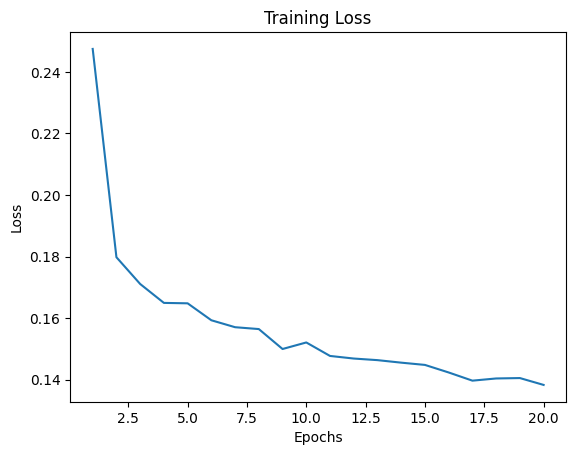

In [13]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import cv2

class ChangeDetectionDataset(Dataset):
    def __init__(self, image_dir_A, image_dir_B, mask_dir, transform=None):
        self.image_dir_A = image_dir_A
        self.image_dir_B = image_dir_B
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir_A)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_A_name = self.image_names[idx]
        img_B_name = img_A_name  # Assuming both image sets have the same filenames

        img_A_path = os.path.join(self.image_dir_A, img_A_name)
        img_B_path = os.path.join(self.image_dir_B, img_B_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(img_A_name)[0] + '.npz')

        image_A = Image.open(img_A_path).convert('RGB')
        image_B = Image.open(img_B_path).convert('RGB')

        mask = create_mask_from_npz(mask_path)

        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image_A, image_B, mask

def create_mask_from_npz(npz_file_path):
    with np.load(npz_file_path) as f:
        polygon_arrays = [v for k, v in f.items() if k.startswith('arr_')]
    
    mask = np.zeros((256, 256), dtype=np.uint8)
    
    for polygons in polygon_arrays:
        if polygons.ndim == 2 and polygons.shape[1] == 2:
            mask = cv2.fillPoly(mask, pts=[polygons], color=1)
    
    # Ensure the mask is binary (0 and 1)
    mask = mask / mask.max()
    
    return mask

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        def upconv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = upconv_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = upconv_block(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = upconv_block(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = upconv_block(128, 64)
        self.decoder1 = conv_block(128, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))
        
        return self.conv_last(dec1)

# Define paths
image_dir_A = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newA'
image_dir_B = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newB'
mask_dir = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/label'

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset and dataloader
dataset = ChangeDetectionDataset(image_dir_A, image_dir_B, mask_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize model, loss function, and optimizer
model = UNet(in_channels=6, out_channels=1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images_A, images_B, masks in tqdm(train_loader):
        images_A = images_A.cuda()
        images_B = images_B.cuda()
        masks = masks.cuda()

        optimizer.zero_grad()
        outputs = model(images_A, images_B)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

# Plotting the loss
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


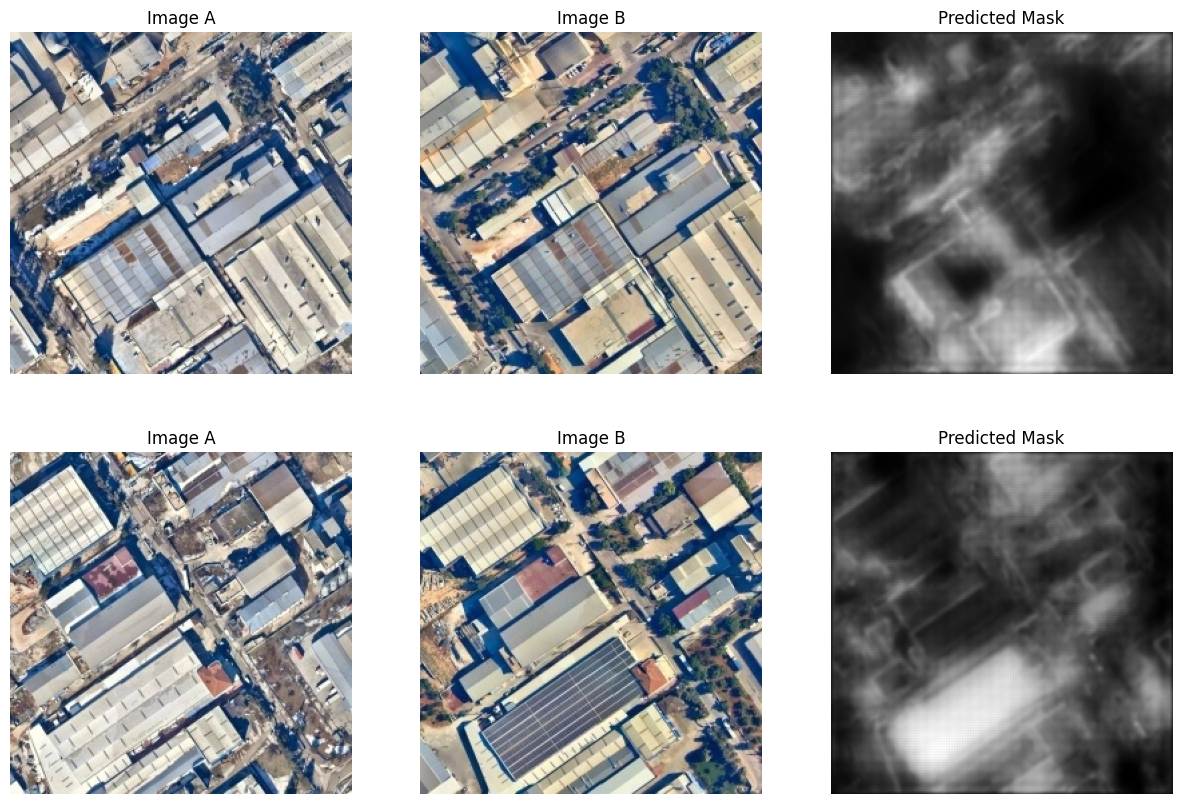

In [14]:
# Define the image pairs to predict on
image_pairs = [
    ('/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/A/79113_50951.jpg', '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/B/79113_50951.jpg'),
    ('/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/A/79113_50952.jpg', '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/B/79113_50952.jpg')
]
image_dir_A="/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/A"
image_dir_B="/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/B"
# Make predictions and plot results
predict_and_plot(model, image_dir_A, image_dir_B, transform, image_pairs)

In [28]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import cv2

class ChangeDetectionDataset(Dataset):
    def __init__(self, image_dir_A, image_dir_B, mask_dir, transform=None):
        self.image_dir_A = image_dir_A
        self.image_dir_B = image_dir_B
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir_A)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_A_name = self.image_names[idx]
        img_B_name = img_A_name  # Assuming both image sets have the same filenames

        img_A_path = os.path.join(self.image_dir_A, img_A_name)
        img_B_path = os.path.join(self.image_dir_B, img_B_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(img_A_name)[0] + '.npz')

        image_A = Image.open(img_A_path).convert('RGB')
        image_B = Image.open(img_B_path).convert('RGB')

        mask = create_mask_from_npz(mask_path)

        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image_A, image_B, mask

def create_mask_from_npz(npz_file_path):
    with np.load(npz_file_path) as f:
        polygon_arrays = [v for k, v in f.items() if k.startswith('arr_')]
    
    mask = np.zeros((256, 256), dtype=np.uint8)
    
    for polygons in polygon_arrays:
        if polygons.ndim == 2 and polygons.shape[1] == 2:
            mask = cv2.fillPoly(mask, pts=[polygons], color=1)
    
    # Ensure the mask is binary (0 and 1)
    mask = mask / mask.max()
    
    return mask

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Load pre-trained VGG16 model
        self.encoder = models.vgg16_bn(pretrained=True).features

        # Modify the input layer to accommodate in_channels
        self.encoder[0] = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        def upconv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = upconv_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = upconv_block(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = upconv_block(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = upconv_block(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        
        enc1 = self.encoder[0:6](x)   # Output: 64 channels
        enc2 = self.encoder[6:13](enc1)  # Output: 128 channels
        enc3 = self.encoder[13:23](enc2) # Output: 256 channels
        enc4 = self.encoder[23:33](enc3) # Output: 512 channels
        bottleneck = self.encoder[33:](enc4) # Output: 512 channels
        
        bottleneck = self.bottleneck(bottleneck)

        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4[:, :, :dec4.size(2), :dec4.size(3)]), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3[:, :, :dec3.size(2), :dec3.size(3)]), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2[:, :, :dec2.size(2), :dec2.size(3)]), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1[:, :, :dec1.size(2), :dec1.size(3)]), dim=1))

        return self.conv_last(dec1)

# Define paths
image_dir_A = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newA'
image_dir_B = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/newB'
mask_dir = '/kaggle/input/preprocessed-change/change_detection_dataset_poly_preprocessed/label'

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset and dataloader
dataset = ChangeDetectionDataset(image_dir_A, image_dir_B, mask_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize model, loss function, and optimizer
model = UNet(in_channels=6, out_channels=1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images_A, images_B, masks in tqdm(train_loader):
        images_A = images_A.cuda()
        images_B = images_B.cuda()
        masks = masks.cuda()

        optimizer.zero_grad()
        outputs = model(images_A, images_B)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

# Plotting the loss
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


  0%|          | 0/209 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([4, 1, 256, 256])) must be the same as input size (torch.Size([4, 1, 128, 128]))